Plot panel wrfout-cross

In [1]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.colors as colors
import numpy as np
from netCDF4 import Dataset
from wrf import getvar, xy, interpline, to_np, vertcross, smooth2d, CoordPair, get_basemap, latlon_coords
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
%matplotlib inline


##def fuctions

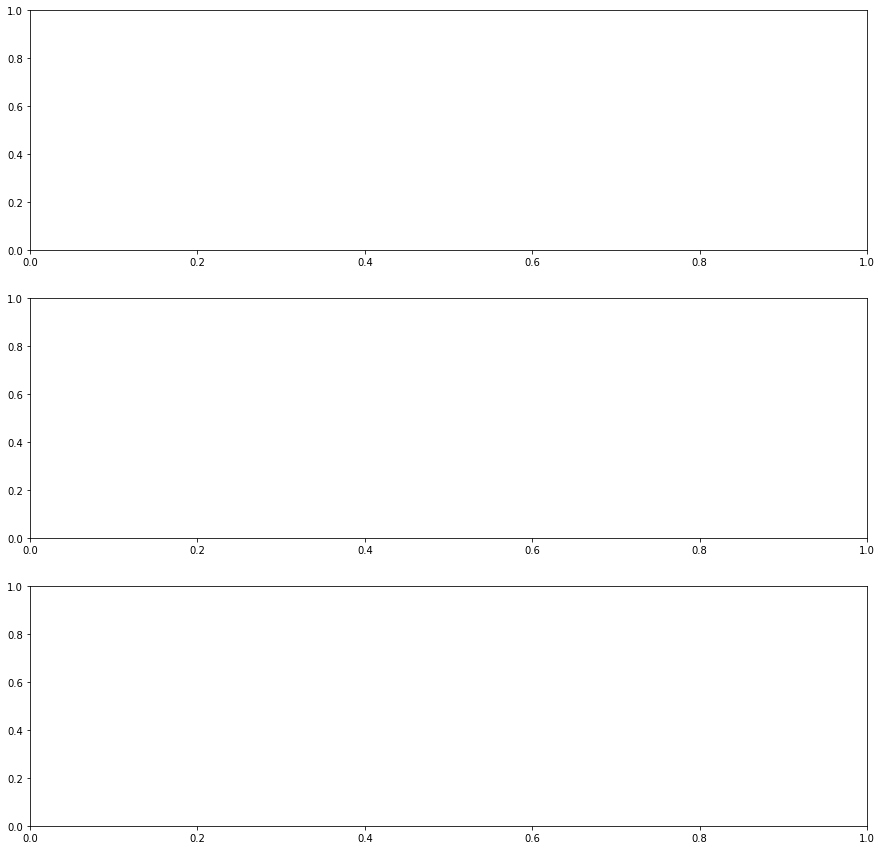

In [2]:
fig, big_axes = plt.subplots(figsize=(15.0, 15.0) , nrows=3, ncols=1, sharey=True) 

#for row, big_ax in enumerate(big_axes, start=1):
    #big_ax.set_title("Subplot row %s \n" % row, fontsize=16)

    # Turn off axis lines and ticks of the big subplot 
    # obs alpha is 0 in RGBA string!
 #   big_ax.tick_params(labelcolor=(0,0,0,0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
  #  big_ax._frameon = False

In [3]:
def get_axis_limits(ax, scalex=.03,scaley=0.93):
    return ax.get_xlim()[1]*scalex, ax.get_ylim()[1]*scaley
axes=['ax1', 'ax2','ax3','ax4','ax5','ax6','ax7','ax8','ax9','ax10','ax11','ax12']
NUM=['A', 'B','C','D','E','F','G','H','I','G','K','L']
for i in range(0,12):
    axes[i] = fig.add_subplot(3,4,i+1)
    plt.subplots_adjust(left=0.05,right=0.95,top=0.90,bottom=0.05,wspace=0.15,hspace=0.05)
    #axes[i].set_title('Plot title ' + str(i+1))
    #axes[i].annotate(NUM[i], xy=get_axis_limits(axes[i]))
fig.set_facecolor('w')
plt.tight_layout()

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        # https://matplotlib.org/users/colormapnorms.html#custom-normalization-two-linear-ranges
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
# Open the NetCDF file
def plot_cross(filename,lat0,lon0,lat1,lon1,i):
    ncfile = Dataset(filename)
# Get the WRF variables
    slp = getvar(ncfile, "slp")
    smooth_slp = smooth2d(slp, 3)
    ctt = getvar(ncfile, "PREC_ACC_NC")
    z = getvar(ncfile, "z")
    dbz = getvar(ncfile, "dbz")
    Z = 10**(dbz/10.)
    wspd =  getvar(ncfile, "wa", units="m s-1")
    pblh = getvar(ncfile, "PBLH")
    ccn4 = getvar(ncfile, "CCN4")
# Set the start point and end point for the cross section
    start_point = CoordPair(lat=lat0, lon=lon0)
    print(start_point.lon)
    print(start_point.lat)
    end_point = CoordPair(lat=lat1, lon=lon1)

# Compute the vertical cross-section interpolation.  Also, include the lat/lon points
# along the cross-section in the metadata by setting latlon to True.
    z_cross = vertcross(Z, z, wrfin=ncfile, start_point=start_point, end_point=end_point,
                    latlon=True, meta=True)
    wspd_cross = vertcross(wspd, z, wrfin=ncfile, start_point=start_point, end_point=end_point,
                       latlon=True, meta=True)
    ccn4_cross = vertcross(ccn4, z, wrfin=ncfile, start_point=start_point, end_point=end_point,
                       latlon=True, meta=True)
    dbz_cross = 10.0 * np.log10(z_cross)
    pblh_line =interpline(pblh,  wrfin=ncfile,start_point=start_point, end_point=end_point,
                       latlon=True, meta=True)
# Get the latitude and longitude points
    lats, lons = latlon_coords(slp)

# Get the basemap object
    bm = get_basemap(slp)

# Convert the lat/lon points in to x/y points in the projection space
    x, y = bm(to_np(lons), to_np(lats))

# Make the pressure contours
    contour_levels = [1001, 1002, 1003, 1004, 1005, 1006,1007,1008,1009]
    c1 = bm.contour(x, y, to_np(smooth_slp), levels=contour_levels, colors="blue",
                zorder=3, linewidths=1.0, ax=axes[i],alpha=0.5)
    plt.clabel(c1, inline=1, fontsize=10, fmt="%i",alpha=0.5)
# Create the filled cloud top temperature contours
    contour_levels = [ 0,5, 10,15,20,25,30,35,40,45,50,55,60]
    ctt_contours = bm.contourf(x, y, to_np(ctt), contour_levels, cmap=get_cmap("Greys"),
                           zorder=2, ax=axes[i])

    spoint_x, spoint_y = bm(start_point.lon,start_point.lat)
    epoint_x, epoint_y = bm(end_point.lon,end_point.lat)
    bm.plot([spoint_x, epoint_x], [spoint_y, epoint_y], color="yellow",
        marker="o", markersize=5,zorder=3, ax=axes[i],alpha=0.5,linewidth=2.0)

# Create the color bar for cloud top temperature
    #cb_ctt = fig.colorbar(ctt_contours, ax=axes[i], extend='both',shrink=.60)
    #cb_ctt.ax.tick_params(labelsize=9)

# Draw Parallels
    parallels = np.arange(np.amin(lats), np.amax(lats), 0.5)
    if i ==0 :
        bm.drawparallels(np.round(parallels,decimals=2), ax=axes[i], color="white",labels=[1,0,0,0],fontsize=15)

    merids = np.arange(np.amin(lons), np.amax(lons), 0.5)
    bm.drawmeridians(np.round(merids,decimals=2), ax=axes[i], color="white",labels=[0,0,0,1],rotation=18,fontsize=15)

# Crop the image to the hurricane region
    x_start, y_start = bm(np.amin(lons), np.amin(lats))
    x_end, y_end = bm(np.amax(lons), np.amax(lats))
    axes[i].set_xlim([x_start, x_end])
    axes[i].set_ylim([y_start, y_end])
# Make the contour plot for wspd
    cmap=get_cmap("Spectral")
#cmap.set_bad('white', 0)
    contour_levels = [-3, -2, -1, 0, 1, 2,3,4,5,6,7,8]
    wspd_contours = axes[i+4].contourf(to_np(wspd_cross), contour_levels,cmap='RdBu_r', norm=MidpointNormalize(midpoint=0.))
#pblh_contours = axes[i+4].contour(to_np(pblh_line), cmap=get_cmap("jet"))
    ax2_wspd = axes[i+4].twinx()
    pblh_pline = ax2_wspd.plot(pblh_line,c='k',linewidth=4.0)
# Add the color bar
    #cb_wspd = fig.colorbar(wspd_contours, extend='both',ax=axes[i+4])
    #cb_wspd.ax.tick_params(labelsize=9)

# Make the contour plot for dbz
    levels = [5*n for n in range(13)]
    dbz_contours = axes[i+8].contourf(to_np(dbz_cross), levels=levels, cmap=get_cmap("jet"))
    ccn4_contours = axes[i+8].contour(to_np(ccn4_cross), colors='k',linewidths=0.5)
    plt.clabel(ccn4_contours, inline=True, inline_spacing=1, fmt='%1.0f',rightside_up=True, fontsize=15)
    #cb_dbz = fig.colorbar(dbz_contours, extend='both',ax=axes[i+8])
    #cb_dbz.ax.tick_params(labelsize=9)

# Set the x-ticks to use latitude and longitude labels.
    coord_pairs = to_np(dbz_cross.coords["xy_loc"])
    x_ticks = np.arange(coord_pairs.shape[0])
    #x_labels = [pair.latlon_str() for pair in to_np(coord_pairs)]
    x_labels = [pair.latlon_str(fmt="{:.1f}, {:.1f}") for pair in to_np(coord_pairs)]
    axes[i+4].set_xticks(x_ticks[::10])
    axes[i+4].set_xticklabels([], rotation=30)
    axes[i+8].set_xticks(x_ticks[::10])
    axes[i+8].set_xticklabels(x_labels[::10], rotation=18, fontsize=15)
#ax2_wspd.set_xlim(x_ticks.min(),x_ticks.max())
    ax2_wspd.margins(x=0)
# Set the y-ticks to be height.
#print(dbz_cross.coords)
    vert_vals = to_np(dbz_cross.coords["vertical"])
    v_ticks = np.arange(vert_vals.shape[0])
#np.round(vert_vals) wrong
    if i ==0 :
        axes[i+4].set_yticks(v_ticks[::20])
        axes[i+4].set_yticklabels(np.around(vert_vals[::20],decimals=-2), fontsize=15)
    if i !=0 :
        axes[i+4].yaxis.set_visible(False)
    ax2_wspd.yaxis.set_visible(False)
#######same ytick with heights#####
    ax2_wspd.yaxis.set_visible(False)
    ax2_wspd.set_ylim(min(vert_vals),max(vert_vals))
    if i ==0 :
        axes[i+8].set_yticks(v_ticks[::20])
        axes[i+8].set_yticklabels(np.around(vert_vals[::20],decimals=-2), fontsize=15) 
    if i !=0 :
        axes[i+8].yaxis.set_visible(False)
# Set the x-axis and  y-axis labels
    #axes[i+8].set_xlabel("Latitude, Longitude", fontsize=10)
    #axes[i+4].set_ylabel("Height (m)", fontsize=10)
    #axes[i+8].set_ylabel("Height (m)", fontsize=10)
# Add titles
#    axes[i].set_title("Precipitation (mm/h)", {"fontsize" : 10})
#    axes[i+4].set_title(r"Wind Speed (m $s^{-3}$)", {"fontsize" : 10})
#    axes[i+8].set_title(r"Reflectivity(dBZ)& CCN(S=0.2%,$cm^{-3}$) ", {"fontsize" : 10})
    return ctt_contours,wspd_contours,dbz_contours 

118.0
31.36
118.47
31.252
118.5
31.21
118.2
31.36


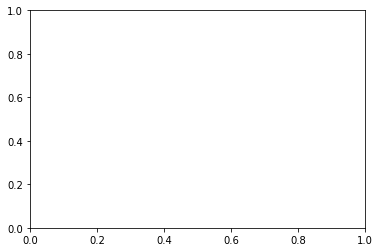

In [4]:
plot_cross('chem_d04_2017-06-10_04:00:00','31.36','118.0','32.0','119.5',0)
plot_cross('02chem_d04_2017-06-10_04:00:00','31.252','118.47','31.72','119.6',1)
plot_cross('10chem_d04_2017-06-10_04:00:00','31.21','118.5','31.76','119.6',2)
ctt,wspd,dbz=plot_cross('100chem_d04_2017-06-10_04:00:00','31.36','118.2','31.85','119.5',3)
for i in range(0,12):
    axes[i].annotate(NUM[i], xy=get_axis_limits(axes[i]),fontsize=15)
#plt.tight_layout()

In [6]:
#plt.tight_layout()
# Add titles
big_axes[0].set_title("Precipitation (mm/h)", {"fontsize" : 20})
big_axes[1].set_title(r"Wind Speed (m $s^{-3}$)", {"fontsize" : 20})
big_axes[2].set_title(r"Reflectivity(dBZ)& CCN(S=0.2%,$cm^{-3}$) ", {"fontsize" : 20})
#[left, bottom, width, height] 
cax = fig.add_axes([1.01, 0.75, 0.02, 0.2])
cax1 = fig.add_axes([1.01, 0.42, 0.02, 0.2])
cax2 = fig.add_axes([1.01, 0.08, 0.02, 0.2])
# The colorbar is also based on this master image.
cbar=fig.colorbar(ctt, cax, orientation='vertical')
cbar.ax.tick_params(labelsize=15)
cbar1=fig.colorbar(wspd, cax1, orientation='vertical')
cbar1.ax.tick_params(labelsize=15)
cbar2=fig.colorbar(dbz, cax2, orientation='vertical')
cbar2.ax.tick_params(labelsize=15)
fig.text(0.5, -0.04, 'Latitude, Longitude', ha='center',fontsize=20)
fig.text(-0.02, 0.35, 'Height (m)', va='center', rotation='vertical',fontsize=20)
#plt.savefig("cross_panel3.png",dpi=600,bbox_inches='tight')
plt.show()

/public/home/hysplit/software/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
